In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
from dataval.dataset import WeatherDataset
from dataval.train import Trainer

import os
import matplotlib.pyplot as plt
import pandas as pd

# Training Pipelines

In this notebook, we load the weather dataset (described in https://arxiv.org/pdf/2107.07455.pdf). We split the dataset into weekly partitions. Then we create 2 pipelines: one that trains a model on the first week & deploys on all following weeks, and another that continually trains & deploys on each consecutive pair of weeks.

In [12]:
# Load dataset

ds = WeatherDataset(os.path.join(os.getcwd(), "canonical-partitioned-dataset"), sample_frac=0.2)

## Train-Once

We use a catboost model, optimizing for RMSE of weather prediction. We use off-the-shelf models/parameters (no ensembling or uncertainty estimation to keep things simple).

In [35]:
first_iter = True
test_mses = {}
train_mse = None

for train_df, test_df in ds.iterate():
    X_train, y_train = ds.split_feature_label(train_df)
    
    if first_iter:
        catboost_hparams = {"depth": 5, "iterations": 250, "learning_rate": 0.03, "loss_function": "RMSE"}
        t = Trainer(catboost_hparams)
        print(f"Training for {ds.get_partition_key(train_df)}...")
        t.fit(X_train, y_train, verbose=100)
        first_iter = False

        train_mse = t.score(X_train, y_train)
    
    # Evaluate
    X_test, y_test = ds.split_feature_label(test_df)
    test_mses[ds.get_partition_key(test_df)] = t.score(X_test, y_test)

Training for 2018_35...
0:	learn: 6.8902767	test: 6.6570720	best: 6.6570720 (0)	total: 2.59ms	remaining: 644ms
100:	learn: 2.2496987	test: 2.3903089	best: 2.3903089 (100)	total: 345ms	remaining: 509ms
200:	learn: 2.0115532	test: 2.2694706	best: 2.2694706 (200)	total: 674ms	remaining: 164ms
249:	learn: 1.9457435	test: 2.2457269	best: 2.2457269 (249)	total: 851ms	remaining: 0us

bestTest = 2.245726949
bestIteration = 249



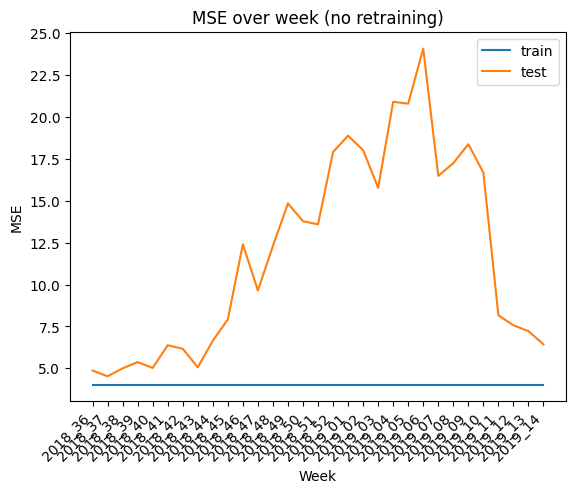

In [36]:
plt.plot(test_mses.keys(), [train_mse] * len(test_mses.keys()), label="train")
plt.plot(test_mses.keys(), test_mses.values(), label="test")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Week")
plt.ylabel("MSE")
plt.title("MSE over week (no retraining)")
plt.legend()
plt.show()

Wow, it looks like the MSE gets significantly worse as we deploy over time! Makes sense, as the seasons change.

## Continual-Train

In [37]:
test_mses = {}
train_mses = {}

for train_df, test_df in ds.iterate():
    X_train, y_train = ds.split_feature_label(train_df)
    
    catboost_hparams = {"depth": 5, "iterations": 250, "learning_rate": 0.03, "loss_function": "RMSE"}
    continual_t = Trainer(catboost_hparams)
    continual_t.fit(X_train, y_train, verbose=False)
    train_mses[ds.get_partition_key(train_df)] = continual_t.score(X_train, y_train)
    
    # Evaluate
    X_test, y_test = ds.split_feature_label(test_df)
    test_mses[ds.get_partition_key(test_df)] = continual_t.score(X_test, y_test)

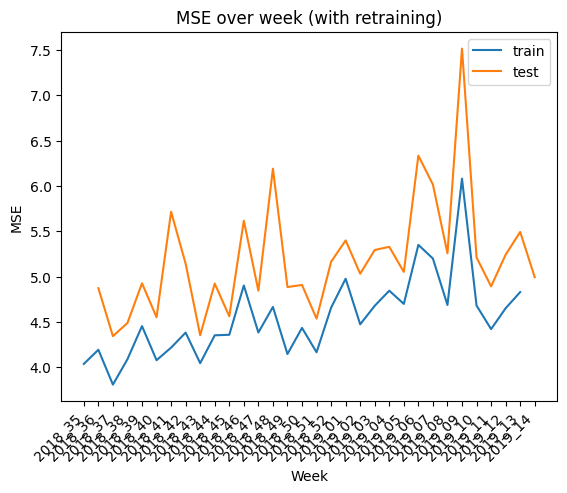

In [38]:
plt.plot(train_mses.keys(), train_mses.values(), label="train")
plt.plot(test_mses.keys(), test_mses.values(), label="test")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Week")
plt.ylabel("MSE")
plt.title("MSE over week (with retraining)")
plt.legend()
plt.show()

The MSEs improve here, because we're retraining on fresh data.

In [40]:
continual_t.get_feature_importance().head(25)

,feature,importance
6,cmc_0_0_0_2_interpolated,21.769925
89,gfs_temperature_sea_interpolated,17.953149
109,wrf_t2_interpolated,11.310435
99,wrf_t2,9.916718
8,cmc_0_0_0_2,8.525895
100,wrf_t2_next,7.191259
87,gfs_temperature_sea,5.675427
7,cmc_0_0_0_2_next,2.866797
90,gfs_temperature_sea_next,2.326574
1,sun_elevation,1.629378
